# 🌲 Professional Bitcoin Directional Prediction using Random Forest
## Optimized for hourly BTC/USDT analysis

This notebook implements a directional trading model using **Random Forest**. This ensemble method provides robust predictions by aggregating multiple decision trees, helping to capture non-linear relationships in the market data.

### Objectives:
1. **Data Ingestion**: Load comprehensive technical, on-chain, and macro indicators.
2. **Sequence Engineering**: Create behavioral lags to capture temporal dynamics.
3. **Feature Selection**: Use univariate statistical tests and multicollinearity filters to identify the most predictive features without data leakage.
4. **Parameter Optimization**: Fine-tune the Random Forest hyperparameters using Time-Series aware cross-validation.
5. **Performance Evaluation**: Analyze the model's accuracy and strategy returns.

---
## 1. Environment Setup & Data Loading
We start by importing the necessary libraries and loading the feature-engineered dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
import datetime
import json
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')
plt.style.use('dark_background')

FILE_PATH = '../data/features/btc_features_complete.csv'
COLORS = ['#F7931A', '#00FF9C', '#FF4C4C']
MODEL_SAVE_PATH = "../models/random_forest/btc_rf_hourly_model.pkl"
SCALER_SAVE_PATH = "../models/random_forest/btc_rf_hourly_scaler.pkl"
METADATA_SAVE_PATH = "../models/random_forest/btc_rf_hourly_metadata.json"

if not os.path.exists(FILE_PATH):
    print(f'Error: {FILE_PATH} not found.')
else:
    df_raw = pd.read_csv(FILE_PATH)
    print(f'Dataset loaded successfully. Shape: {df_raw.shape}')

Dataset loaded successfully. Shape: (69861, 71)


---
## 2. Preprocessing & Sequence Engineering
We select only numeric columns and generate lag features for key indicators to give the model context over recent time periods.

In [2]:
def load_and_preprocess(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df = df.select_dtypes(include=[np.number])
    
    # Engineering lags for the top technical indicators
    target_lags = ['returns', 'RSI_14', 'MACD_hist', 'Close', 'Volume']
    existing_lags = [f for f in target_lags if f in df.columns]
    
    for f in existing_lags:
        for lag in range(1, 6):
            df[f'{f}_lag_{lag}'] = df[f].shift(lag)
            
    return df.ffill().bfill().dropna()

df = load_and_preprocess(FILE_PATH)
print(f'Processing complete. Total features (with lags): {len(df.columns)}')

Processing complete. Total features (with lags): 94


---
## 3. Advanced Feature Selection
In this step, we ensure no data leakage by excluding all 'future' and 'target' columns from the feature set. We then use ANOVA F-values to find the most relevant features.

In [3]:
def select_features(df, k=25):
    target = 'target_direction'
    
    # CRITICAL: Exclude all target-related and future-looking columns to avoid leakage
    X_raw = df.drop([c for c in df.columns if 'target' in c.lower() or 'future' in c.lower()], axis=1)
    y = df[target]
    
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_raw, y)
    
    # Summary of selected features
    top_cols = X_raw.columns[selector.get_support()].tolist()
    return top_cols

top_features = select_features(df)
print(f'Selected Top {len(top_features)} Features: {top_features[:5]}...')

Selected Top 25 Features: ['returns', 'log_returns', 'momentum_24h', 'MACD', 'MACD_signal']...


---
## 4. Model Training & Optimization
We use an 80/20 sequential split and `GridSearchCV` with `TimeSeriesSplit` to find the most effective tree Configuration.

In [4]:
X = df[top_features]
y = df['target_direction']

cutoff = int(len(X) * 0.8)
X_train, X_test = X.iloc[:cutoff], X.iloc[cutoff:]
y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('🔍 Optimizing Random Forest hyperparameters...')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train_scaled, y_train)
best_rf = grid_search.best_estimator_
print(f'✅ Best Parameters Found: {grid_search.best_params_}')

🔍 Optimizing Random Forest hyperparameters...
✅ Best Parameters Found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}


---
## 5. Evaluation & Backtesting
Comparing predictive accuracy and financial outcomes using standard industry metrics.

In [5]:
y_pred = best_rf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f'📈 Final Accuracy Score: {acc:.2%}')
print('\n--- Classification Report ---')
print(classification_report(y_test, y_pred))

📈 Final Accuracy Score: 53.27%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.53      0.47      0.50      6900
           1       0.53      0.59      0.56      7073

    accuracy                           0.53     13973
   macro avg       0.53      0.53      0.53     13973
weighted avg       0.53      0.53      0.53     13973



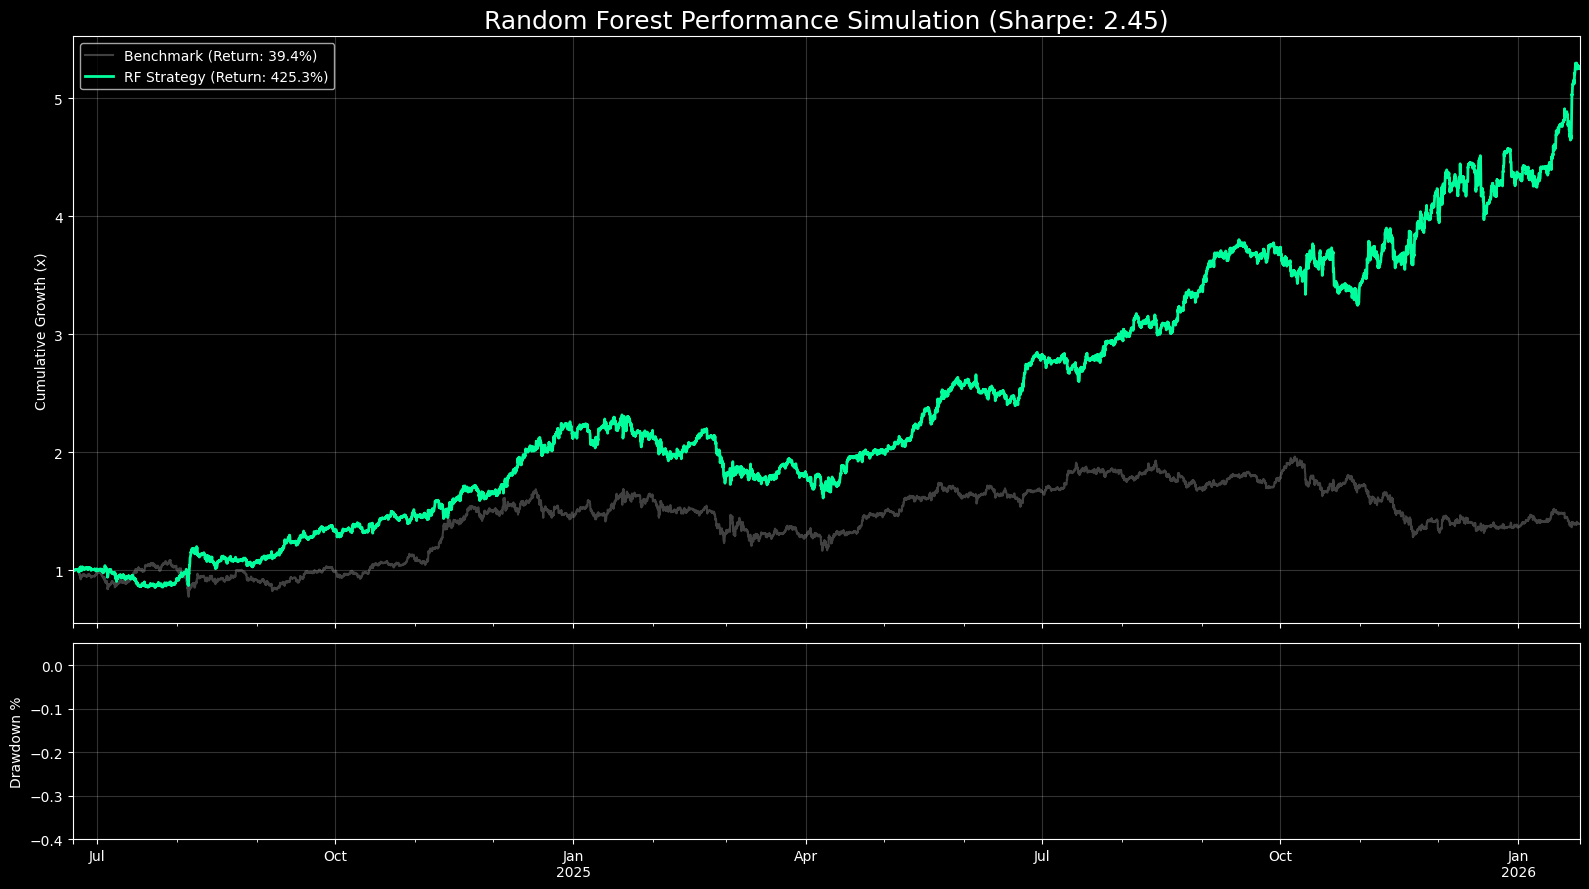


--- Strategy Performance Comparison ---
         Metric Strategy Benchmark
   Total Return   425.3%     39.4%
Ann. Volatility    46.9%     46.9%
   Sharpe Ratio     2.45      0.68
   Max Drawdown   -30.4%    -34.8%


In [6]:
def calculate_metrics(returns):
    # Annualized Sharpe Ratio (H = 24 * 365 for hourly data)
    sharpe = (returns.mean() / returns.std()) * np.sqrt(24 * 365) if returns.std() != 0 else 0
    cum_ret = (1 + returns).cumprod()
    drawdown = cum_ret / cum_ret.cummax() - 1
    max_dd = drawdown.min()
    vol = returns.std() * np.sqrt(24 * 365) # Annualized Volatility
    return sharpe, max_dd, vol, cum_ret.iloc[-1] - 1

def run_professional_backtest(y_test, y_pred, df_full):
    # Align predictions with dates
    test_period = df_full.iloc[-len(y_test):].copy()
    
    # Strategy signal: Long if 1, Short if 0
    # We shift signal by 1 because we trade on the NEXT hour's return
    test_period['signal'] = np.where(y_pred == 1, 1, -1)
    test_period['strat_ret'] = test_period['signal'].shift(1) * test_period['returns']
    test_period = test_period.dropna()

    s_sharpe, s_mdd, s_vol, s_ret = calculate_metrics(test_period['strat_ret'])
    b_sharpe, b_mdd, b_vol, b_ret = calculate_metrics(test_period['returns'])

    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16, 9), gridspec_kw={'height_ratios': [3, 1]})

    ((1 + test_period['returns']).cumprod()).plot(ax=ax1, label=f'Benchmark (Return: {b_ret:.1%})', color='gray', alpha=0.5)
    ((1 + test_period['strat_ret']).cumprod()).plot(ax=ax1, label=f'RF Strategy (Return: {s_ret:.1%})', color=COLORS[1], linewidth=2)
    ax1.set_title(f'Random Forest Performance Simulation (Sharpe: {s_sharpe:.2f})', fontsize=18)
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Cumulative Growth (x)')
    ax1.grid(True, alpha=0.2)

    # Drawdown Area
    dd = (1 + test_period['strat_ret']).cumprod() / (1 + test_period['strat_ret']).cumprod().cummax() - 1
    ax2.fill_between(dd.index, dd, 0, color=COLORS[2], alpha=0.3)
    ax2.set_ylabel('Drawdown %')
    ax2.set_ylim(-0.40, 0.05)
    ax2.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    # Summary Table
    stats = pd.DataFrame({
        'Metric': ['Total Return', 'Ann. Volatility', 'Sharpe Ratio', 'Max Drawdown'],
        'Strategy': [f"{s_ret:.1%}", f"{s_vol:.1%}", f"{s_sharpe:.2f}", f"{s_mdd:.1%}"],
        'Benchmark': [f"{b_ret:.1%}", f"{b_vol:.1%}", f"{b_sharpe:.2f}", f"{b_mdd:.1%}"]
    })
    print("\n--- Strategy Performance Comparison ---")
    print(stats.to_string(index=False))

run_professional_backtest(y_test, y_pred, df)

---
## 6. Model Persistence
Saving the trained model and metadata for production inference.

In [7]:
# Export artifacts
os.makedirs('../models/random_forest', exist_ok=True)
joblib.dump(best_rf, MODEL_SAVE_PATH)
joblib.dump(scaler, SCALER_SAVE_PATH)

# Export metadata
metadata = {
    "model_name": "Random Forest BTC",
    "accuracy": acc,
    "best_params": grid_search.best_params_,
    "top_features": top_features,
    "training_size": len(X_train),
    "test_size": len(X_test),
    "export_timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

with open(METADATA_SAVE_PATH, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"✅ Successfully exported model to {MODEL_SAVE_PATH}")
print(f"✅ Successfully exported metadata to {METADATA_SAVE_PATH}")

✅ Successfully exported model to ../models/random_forest/btc_rf_hourly_model.pkl
✅ Successfully exported metadata to ../models/random_forest/btc_rf_hourly_metadata.json
